In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
import json
import pandas as pd

pd.options.mode.chained_assignment = None

os.environ["SINO_USER"] = "7026108732"

In [3]:
from sino.scraper import get_points
from sino.tracks import clean

In [4]:
points = get_points(start_date="30032025")

Page 1: 200 / 629
Page 2: 400 / 629
Page 3: 600 / 629
Page 4: 629 / 629


In [12]:
tracks, df = clean(points)

Mosaicing tiles.


In [13]:
df[:10].T

,0,1,2,3,4,5,6,7,8,9
index,4,5,6,7,8,9,10,11,12,13
nID,17040,17042,17044,17046,17048,17050,17052,17041,17043,17045
strTEID,7026108732,7026108732,7026108732,7026108732,7026108732,7026108732,7026108732,7026108732,7026108732,7026108732
nTime,1743402323,1743402328,1743402330,1743402336,1743402337,1743402339,1743402340,1743402353,1743402358,1743402363
dbLon,2.359995,2.359785,2.359723,2.359277,2.359237,2.359163,2.359108,2.358847,2.358805,2.358762
dbLat,48.822223,48.822143,48.822138,48.822012,48.822018,48.822017,48.822018,48.822067,48.822072,48.822088
nDirection,198,3,222,283,221,236,251,189,189,189
nSpeed,9,5,12,5,5,12,11,0,0,0
nGSMSignal,0,0,0,0,0,0,0,0,0,0
nGPSSignal,0,0,0,0,0,0,0,0,0,0


In [201]:
import elevatr as elv

def get_elevations(lon_col, lat_col):
    bottom_left = (
        float(lon_col.min()), 
        float(lat_col.min()),
    )

    top_right = (
        float(lon_col.max()), 
        float(lat_col.max()),
    )
    
    # Define the bounding box of the area of interest (min_lon, min_lat, max_lon, max_lat)
    bbx = bottom_left + top_right
    # Set the level of precision (between 0 and 14)
    zoom = 12

    print("BBOX", bbx)

    # Access the elevation data
    raster_raw = elv.get_elev_raster(locations=bbx, zoom=zoom, crs="EPSG:4326")
    raster = raster_raw.to_numpy()
    
    def get_elevation(lon, lat, raster):
        assert lon <= top_right[0] and lat <= top_right[1]
        assert lon >= bottom_left[0] and lat >= bottom_left[1]
        
        get_lat_idx = lambda lat: int((lat - bottom_left[1]) / (top_right[1] - bottom_left[1]) * raster.shape[1])
        get_lon_idx = lambda lon: int((lon - bottom_left[0]) / (top_right[0] - bottom_left[0]) * raster.shape[0])

        lon_idx = min(get_lon_idx(lon), raster.shape[0] - 1)
        lat_idx = min(get_lat_idx(lat), raster.shape[1] - 1)

        return raster[lon_idx, lat_idx]
    
    elevations = [get_elevation(lon, lat, raster) for lon, lat in zip(lon_col, lat_col)]
    return raster_raw,elevations

raster_raw, elevations = get_elevations(df.dbLon, df.dbLat)
df["elevation"] = elevations

BBOX (2.299035, 48.81563, 2.4486683, 48.8747533)


Mosaicing tiles.


In [205]:
df.elevation

0        49
1        49
2        50
3        50
4        50
         ..
12297    34
12298    34
12299    29
12300    30
12301    42
Name: elevation, Length: 12302, dtype: int16

In [204]:
df.dbLon.max(), df.dbLat.max(), df.dbLon.min(), df.dbLat.min()

(np.float64(2.4486683),
 np.float64(48.8747533),
 np.float64(2.299035),
 np.float64(48.81563))

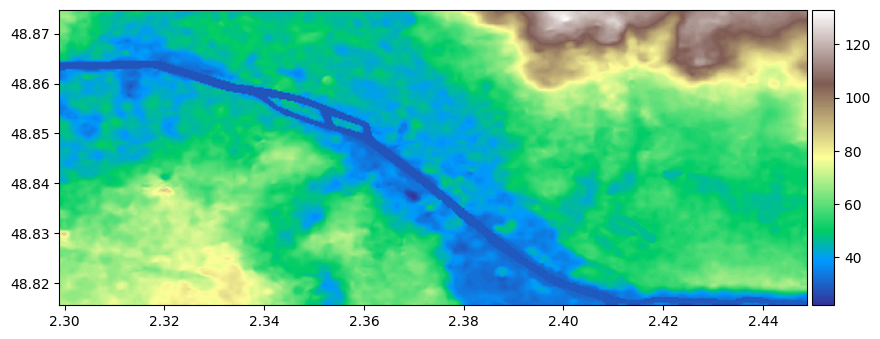

In [202]:
raster_raw.show(cmap='terrain', clip_zero=True)

In [22]:
paths = []
for trackID, d in df.groupby("trackID"):
    track = tracks[tracks.trackID == trackID].squeeze()
    values = d[["dbLat", "dbLon", "dist_total", "nSpeed", "duration_total", "elevation", "d_plus"]].to_dict(orient="list")
    path = list(zip(values["dbLon"], values["dbLat"]))
    timestamps = list(d.nTime - d.nTime.min())
    start = int(d.nTime.min())

    paths.append(
        dict(
            path=path,
            timestamps=timestamps,
            speeds=values["nSpeed"],
            distances=values["dist_total"],
            start=start,
            duration_minutes=values["duration_total"],
            trackID=trackID,
            max_speed=float(track.max_speed),
            formatted_start_date=track.formatted_start_date,
            elevations=values["elevation"],
            d_plus=values["d_plus"],
        )
    )

In [25]:
with open("./app/data.json", "w") as f:
    json.dump(paths, f)

In [19]:
import json

with open("./app/data.json", "r") as f:
    data = json.load(f)


In [191]:
paths[0]["elevations"]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [179]:
path

dict_keys(['path', 'timestamps', 'speeds', 'distances', 'start', 'duration_minutes', 'trackID', 'max_speed', 'formatted_start_date'])

In [158]:
bottom_left = (
    float(df.dbLon.min()), 
    float(df.dbLat.min()),
)

top_right = (
    float(df.dbLon.max()), 
    float(df.dbLat.max()),
)

In [155]:
bottom_left = (2.2486769, 48.7766012)
top_right = (2.4507566645673062, 48.927609284796965)

#raster = elv.get_elev_raster(locations=bbx, zoom=zoom, crs="EPSG:4326")

In [157]:
import elevatr as elv



/home/tpetitjean/Code/bicycle/.venv/lib/python3.10/site-packages/rasterio/merge.py:363: UserWarning: Ignoring nodata value. The nodata value, -3.4028234663852886e+38, cannot safely be represented in the chosen data type, float32. Consider overriding it using the --nodata option for better results. Falling back to first source's nodata value.
  warnings.warn(


Mosaicing tiles.


In [134]:
def get_elevation(lon, lat, raster):
    assert lon < top_right[0] and lat < top_right[1]
    assert lon > bottom_left[0] and lat > bottom_left[1]
    
    get_lat_idx = lambda lat: int((lat - bottom_left[1]) / (top_right[1] - bottom_left[1]) * raster.shape[1])
    get_lon_idx = lambda lon: int((lon - bottom_left[0]) / (top_right[0] - bottom_left[0]) * raster.shape[0])

    return raster[get_lon_idx(lon), get_lat_idx(lat)]

In [135]:
lon = 2.35
lat = 48.8

In [136]:
lat = 48.822450741918054
lon = 2.3603157265087287

In [137]:
lat = 48.831717319087865
lon = 2.3555063944530095

In [138]:
elevation = get_elevation(lon, lat, raster)

In [139]:
elevation

np.int16(48)

In [120]:
raster.min()

np.int16(22)

In [121]:
raster.shape # lon x lat

(533, 714)

Mosaicing tiles.


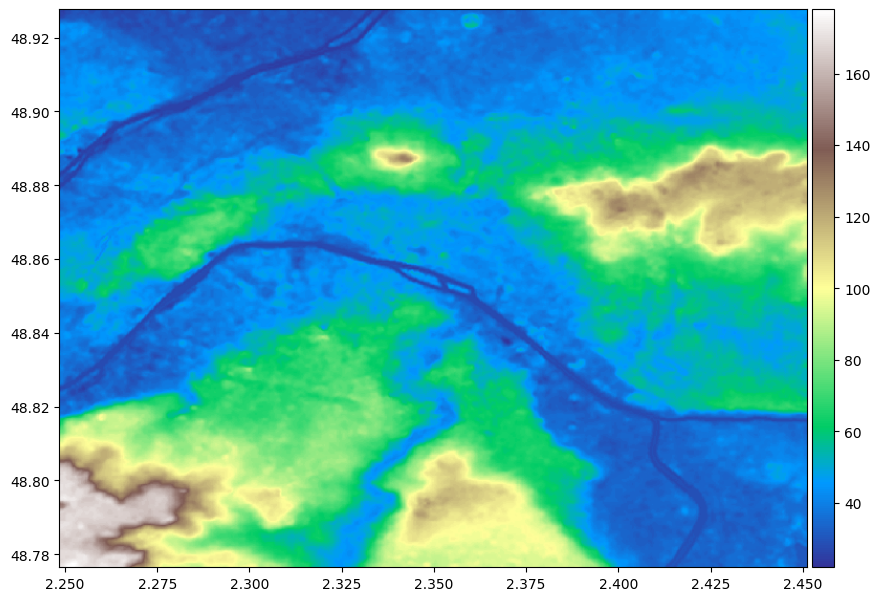

In [122]:
raster.show(cmap='terrain', clip_zero=True)

In [61]:
lat, top_right

(2.2486769, (2.4507566645673062, 48.927609284796965))

lat, top_right

In [51]:
raster.transform.

Affine(4.2674523930418735e-05, 0.0, 2.3672254468520584,
       0.0, -4.2674523930418735e-05, 48.92762343169526)

In [48]:
type(raster.transform)

affine.Affine

In [46]:
?elv.get_elev_raster

Signature:
elv.get_elev_raster(
    locations: Tuple[float, float, float, float],
    zoom: int,
    crs: Optional[str] = 'EPSG:3857',
    clip: Optional[str] = 'bbox',
    cache_folder: Optional[str] = './cache',
    use_cache: Optional[bool] = True,
    delete_cache: Optional[bool] = True,
    verbose: Optional[bool] = True,
) -> Optional[elevatr.raster.Raster]
Docstring:
Get elevation raster for a bounding box. The raster is downloaded from AWS Terrain Tiles.

Parameters
----------
locations : Tuple[float, float, float, float]
    Bounding box coordinates (min_lon, min_lat, max_lon, max_lat) in WGS84/EPSG:4326.
    (min_lon, min_lat) is the bottom-left corner and (max_lon, max_lat) is the top-right corner.
zoom : int
    Zoom level of the raster. Between 0 and 14. Greater zoom level means higher resolution.
crs : str, optional
    Coordinate Reference System of the raster, by default "EPSG:3857" (Web Mercator projection).
clip : str, optional
    Clip the raster to the bounding box 

In [42]:
rn = raster.to_numpy()

In [43]:
rn.shape # H x W / lat x lon

(289, 1946)

In [23]:
import geopy.distance

In [25]:
d = geopy.distance.geodesic(
    (48.7766012, 2.2486769), (48.927609284796965, 2.4507566645673062)
).m

In [31]:
import math

In [34]:
diag = math.sqrt(rn.shape[0]**2 + rn.shape[1]**2)

In [35]:
d / diag # resolution in meters

3.1441263188552697

In [39]:
raster.transform

Affine(4.777314267823499, 0.0, np.float64(250321.56746659693),
       0.0, -4.777314267817928, np.float64(6262587.118773982))

In [37]:
dir(raster)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_resolution',
 'bounds',
 'count',
 'crs',
 'data',
 'driver',
 'dtype',
 'height',
 'imagery_sources',
 'meta',
 'nodata',
 'reproject',
 'resolution',
 'show',
 'to_numpy',
 'to_tif',
 'transform',
 'width']